# Sentiment Analysis of Real-time Flipkart Product Reviews

## Objective :
- The objective of this project is to classify customer reviews as positive or negative and understand the pain points of customers who write negative reviews. 
- By analyzing the sentiment of reviews, we aim to gain insights into product features that contribute to customer satisfaction or dissatisfaction.


### Importing the required libraries. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [ ]:
!pip install emoji

### Importing data 

In [12]:
path = r"D:\reviews_data_dump\reviews_badminton\data.csv"

In [13]:
data = pd.read_csv(path)
data.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [14]:
data.shape

(8518, 8)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [ ]:
data.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

# Data Cleaning 

In [16]:
# droping nan values from review text
data['Review text'].fillna(data['Review text'].mode()[0],inplace=True)

In [17]:
# removing duplicates
data = data.drop_duplicates()

In [18]:
data.duplicated().sum()

0

# Data Preprocessing 

In [19]:
data["Review text"]

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
                              ...                        
8509    Not sure why we have charged for this product ...
8510                                        GoodREAD MORE
8512                                        GoodREAD MORE
8513                                        GoodREAD MORE
8515                                        GoodREAD MORE
Name: Review text, Length: 8514, dtype: object

In [20]:
data["Review text"].apply(lambda x:True if emoji.emoji_count(x)>0 else False).sum()

287

In [21]:
def eda(data,column):
    lower="".join(data[column]).islower()
    html=data[column].apply(lambda x: True if re.search("<.?>",x) else False).sum()
    url=data[column].apply(lambda x: True if re.search("http[s]?://.+?\S+",x) else False).sum()
    tags=data[column].apply(lambda x: True if re.search("#\S+",x) else False).sum()
    mention=data[column].apply(lambda x: True if re.search("@\S+",x) else False).sum()
    un_w=data[column].apply(lambda x: True if re.search("[]\.\*'\-#$%^&(0-9]",x) else False).sum()
    emojiss=data[column].apply(lambda x: True if emoji.emoji_count(x)>0 else False).sum()
    if lower==False:
        print("your data contains both he cases")
    if html>0:
        print("your data contains both html tags")
    if url>0:
        print("your data contains both url")
    if tags>0:
        print("your data contains both tags")
    if mention>0:
        print("your data contains mention")
    if un_w:
        print("your data contains symols and numbers")
    if emojiss>0:
        print("it contains emojis")
    if emojiss>0:
        print("it contains emojis")
data

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8509,NaN,NaN,NaN,NaN,NaN,NaN,Not sure why we have charged for this product ...,1
8510,NaN,NaN,NaN,NaN,NaN,NaN,GoodREAD MORE,1
8512,NaN,NaN,NaN,NaN,NaN,NaN,GoodREAD MORE,2
8513,NaN,NaN,NaN,NaN,NaN,NaN,GoodREAD MORE,5


In [22]:
eda(data,"Review text")

your data contains both he cases
your data contains both tags
your data contains mention
your data contains symols and numbers
it contains emojis
it contains emojis


In [23]:
def basic_pre_proc(x,emoj="F"):
    x=x.lower()  # converting into lowercase
    x=re.sub("<.?>"," ",x) # removing thre html tags
    x=re.sub("http[s]?://.+?\S+"," ",x)      # removing url
    x=re.sub("#\S+"," ",x)  # removing hashtags
    x=re.sub("@\S+"," ",x)  # removing mentions
    if emoj=="T":
        x=emoji.demojize(x)
    x=re.sub("[]\\:-. #$%^&)(0-9]", " ",x)  # removing unwanted char
    return x

In [24]:
import re  # Add this import statement if not already imported
def basic_pre_proc(x, emoj="F"):
    x = x.lower()  # Convert into lowercase
    x = re.sub("<.?>", " ", x)  # Remove the HTML tags
    x = re.sub("http[s]?://.+?\S+", " ", x)  # Remove URLs
    x = re.sub("#\S+", " ", x)  # Remove hashtags
    x = re.sub("@\S+", " ", x)  # Remove mentions
    # Handle emoji preprocessing if required
    if emoj == "T":
        import emoji
        x = emoji.demojize(x)
    x = re.sub("[\\:\-..... #$%^&)(0-9]", " ", x)
    x = re.sub("[@_.!0-9]+", " ", x)
 # Remove unwanted characters
    return x

In [25]:
data["Review text"]=data["Review text"].apply(basic_pre_proc)

In [26]:
data["Review text"]=data["Review text"].apply(basic_pre_proc,args=("T"))

In [27]:
eda(data,"Review text")

your data contains both he cases
your data contains symols and numbers


In [28]:
for i in data['Review text']:
    print(i)

nice product, good quality, but price is now rising which is a bad sign          was an affordable price, especially when we play everyday  so kindly help us out in terms of the price  thank you read more
they didn't supplied yonex mavis      outside cover was yonex ad inside was a cheapest      sad to hear this read more
worst product  damaged shuttlecocks packed in new box  it's not a original yonex product  don't buy flipkart platform is chosen to fraud the buyers read more
quite o  k  , but nowadays  the quality of the corks like not as before   to   years back   i am using mavis     for more than    years quality of corks was very very good at that times, but now i am not getting the quality corks as like before, rate of corks also too much now, i am  very sorry to say like this, but in my experience , my statment is very true to   my knowledgeread more
over pricedjust â?¹      from retailer i didn't understand   wat is d advantage of buying dis frm flipkrtread more
good quality p

In [29]:
def label_rating(rating):
    if rating >= 3:
        return 'positive'
    else:
        return 'negative'
data['label'] = data['Ratings'].apply(label_rating)

<Axes: xlabel='Ratings', ylabel='count'>

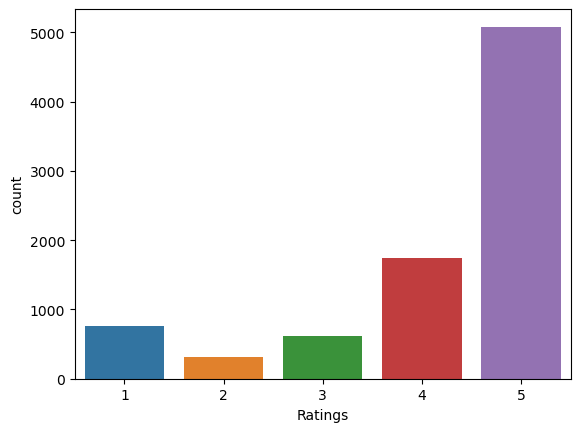

In [30]:
# plotting the rating data
sns.countplot(x='Ratings', data=data)

In [31]:
data

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,label
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"nice product, good quality, but price is now r...",4,positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,they didn't supplied yonex mavis outside ...,1,negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product damaged shuttlecocks packed in ...,1,negative
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"quite o k , but nowadays the quality of the...",3,positive
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,over pricedjust â?¹ from retailer i didn'...,1,negative
...,...,...,...,...,...,...,...,...,...
8509,NaN,NaN,NaN,NaN,NaN,NaN,not sure why we have charged for this product ...,1,negative
8510,NaN,NaN,NaN,NaN,NaN,NaN,goodread more,1,negative
8512,NaN,NaN,NaN,NaN,NaN,NaN,goodread more,2,negative
8513,NaN,NaN,NaN,NaN,NaN,NaN,goodread more,5,positive


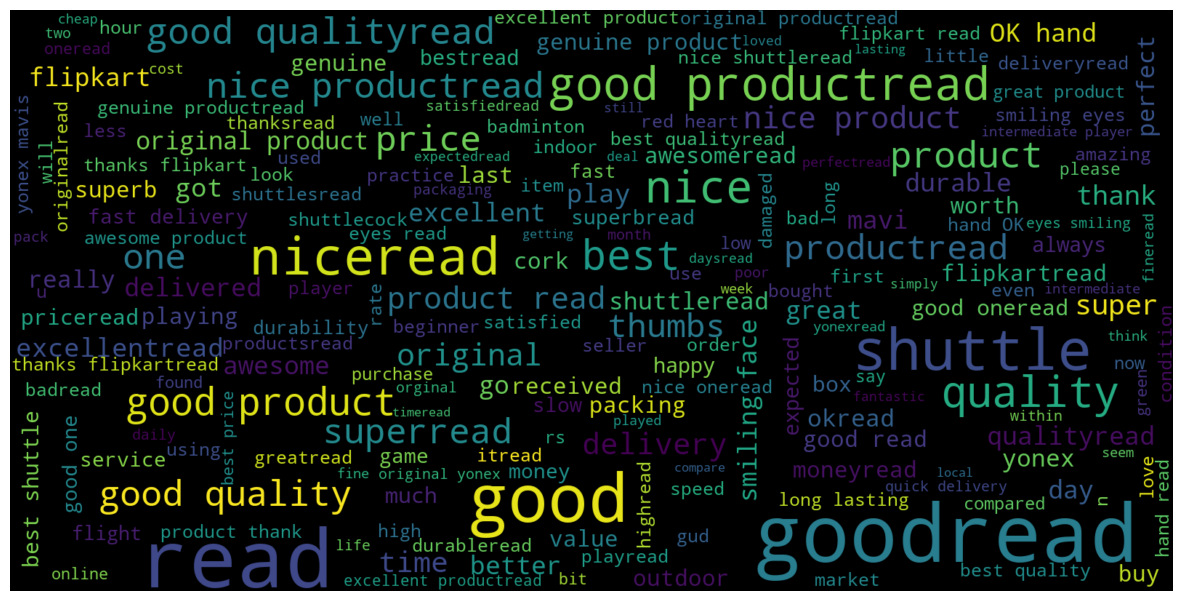

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Assuming 'data' is your DataFrame containing 'Review text' and 'label' columns
positive_reviews = data[data['label'] == 'positive']['Review text'].astype(str)
mon = ' '.join(word for word in positive_reviews)
if mon:  # Check if there are positive reviews
    wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110)
    wordcloud.generate(mon)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("No positive reviews found.")

# Splitting the model 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data[['Review text']], data[['label']], train_size=0.8, random_state=35)

In [34]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [35]:
port = PorterStemmer()
lemma = WordNetLemmatizer()

In [36]:
def preparation(data):
    # removes special characters
    sen = re.sub("[^a-zA-Z]"," ",data)      
    # converts words to lowercase
    sen = sen.lower()
    # tokenization
    sen = sen.split()
    #removes the stop words
    sen = [word for word in sen if word not in stopwords.words('english')]
    # applying lemmatization
    sen = [lemma.lemmatize(word) for word in sen]
    sen=  " ".join(sen)
    return sen

In [37]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
X_test = X_test['Review text'].apply(preparation)
X_train= X_train['Review text'].apply(preparation)

## Converting Text data to Numerical data by CountVectorizer

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
import time

# Initialize CountVectorizer
cv = CountVectorizer()

# Fit and transform X_train
start_time = time.time()
X_train_num = cv.fit_transform(X_train)
end_time = time.time()
print("Time taken for fitting and transforming X_train:", end_time - start_time)

# Transform X_test
start_time = time.time()
X_test_num = cv.transform(X_test)
end_time = time.time()
print("Time taken for transforming X_test:", end_time - start_time)


Time taken for fitting and transforming X_train: 0.05068087577819824
Time taken for transforming X_test: 0.007822275161743164


## Creating model 

### LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train_num, y_train)

LogisticRegression()

In [41]:
y_train_pred = lr_model.predict(X_train_num)
y_pred=lr_model.predict(X_test_num)


In [42]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9254257193188491
              precision    recall  f1-score   support

    negative       0.80      0.51      0.63       208
    positive       0.94      0.98      0.96      1495

    accuracy                           0.93      1703
   macro avg       0.87      0.75      0.79      1703
weighted avg       0.92      0.93      0.92      1703



In [43]:
train_score=accuracy_score(y_train,y_train_pred)
test_score=accuracy_score(y_pred,y_test)
print(train_score)
print(test_score)

0.9425928644839231
0.9254257193188491


### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_num, y_train)

RandomForestClassifier()

In [45]:
y_train_pred = rf_model.predict(X_train_num)
y_pred=lr_model.predict(X_test_num)

In [46]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9254257193188491
              precision    recall  f1-score   support

    negative       0.80      0.51      0.63       208
    positive       0.94      0.98      0.96      1495

    accuracy                           0.93      1703
   macro avg       0.87      0.75      0.79      1703
weighted avg       0.92      0.93      0.92      1703



### Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB
naive= MultinomialNB()
naive.fit(X_train_num,y_train)

MultinomialNB()

In [48]:
y_train_pred = naive.predict(X_train_num)
train_score=accuracy_score(y_train,y_train_pred)
print(train_score)
print(y_train_pred)

0.931874908236676
['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']


In [49]:
pred=naive.predict(X_test_num)
test_score=accuracy_score(pred,y_test)
print(test_score)
print(pred)

0.9236641221374046
['positive' 'positive' 'negative' ... 'positive' 'positive' 'positive']


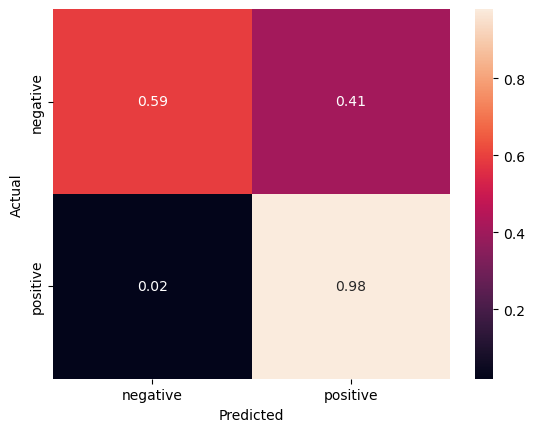

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming y_train_pred is defined earlier in your code
conf_matrix = confusion_matrix(y_train, y_train_pred)
actual = np.sum(conf_matrix, axis=1).reshape(-1, 1)
conf_matrix_normalized = np.round(conf_matrix / actual, 2)
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=naive.classes_, yticklabels=naive.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [51]:
from joblib import Memory
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.metrics import f1_score

In [52]:
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0
pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}
# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
        'vectorization': [CountVectorizer(),TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['elasticnet'],
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}
for algo in pipelines.keys():
    print("*" * 10, algo, "*" * 10)
    grid_search = GridSearchCV(estimator=pipelines[algo],param_grid=param_grids[algo],cv=5,scoring='f1',return_train_score=True,verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[algo] = grid_search.best_estimator_
    y_pred = grid_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label='positive')
    print('F1 Score on Test Data:', f1)

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
F1 Score on Test Data: 0.9547705513370749
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
F1 Score on Test Data: 0.9396378269617706
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
F1 Score on Test Data: 0.9361408353469107


In [53]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', DecisionTreeClassifier())])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.4, penalty='elasticnet',
                                    solver='saga'))])



In [54]:
import joblib
import os

In [57]:
import os
import joblib
from sklearn.metrics import f1_score
save_dir = r"D:\sample_data"
for name, model in best_models.items():
    print("*" * 10, name, "*" * 10)
    file_path = os.path.join(save_dir, f'{name}.pkl')
    try:
        joblib.dump(model, file_path)
        loaded_model = joblib.load(file_path)
        y_test_pred = loaded_model.predict(X_test)
        f1 = f1_score(y_test, y_test_pred, pos_label='positive')
        print("F1 Score (Positive Class):", f1)
        print("Model Size:", os.path.getsize(file_path), "Bytes")
    except FileNotFoundError:
        print("Error: File not found at", file_path)
    except Exception as e:
        print("An error occurred:", e)

********** naive_bayes **********
F1 Score (Positive Class): 0.9547705513370749
Model Size: 82726 Bytes
********** decision_tree **********
F1 Score (Positive Class): 0.9396378269617706
Model Size: 245752 Bytes
********** logistic_regression **********
F1 Score (Positive Class): 0.9361408353469107
Model Size: 58969 Bytes
